In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


train = pd.read_csv("data/train.csv") 
test  = pd.read_csv("data/test.csv")  

train['file_name'] = train['file_name'].apply(lambda x: os.path.join('data', x))
if 'file_name' in test.columns:
    test['file_name'] = test['file_name'].apply(lambda x: os.path.join('data', x))
else:
    # test CSV has column 'id' instead
    test['file_name'] = test['id'].apply(lambda x: os.path.join('data', 'test_data_v2', x))


train_df, val_df = train_test_split(
    train, 
    test_size=0.2, 
    random_state=42, 
    stratify=train['label']
)

def create_generators(train_df, val_df, test_df):
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
    )
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_name',
        y_col='label',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True
    )
    val_generator = test_val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='file_name',
        y_col='label',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=False
    )
    test_generator = test_val_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='file_name',
        y_col=None,
        target_size=(224, 224),
        class_mode=None,
        batch_size=32,
        shuffle=False
    )

    return train_generator, val_generator, test_generator

train_gen, val_gen, test_gen = create_generators(train_df, val_df, test)

Found 63960 validated image filenames.
Found 15990 validated image filenames.
Found 0 validated image filenames.


/Users/parisbozzuti/Desktop/362final_backup/.venv/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:918: UserWarning: Found 5540 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True 

for layer in base_model.layers[:-40]:  
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


2025-12-07 21:09:05.705722: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-07 21:09:05.705771: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-07 21:09:05.705780: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-07 21:09:05.705807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 21:09:05.705823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    verbose=1
)

Epoch 1/10


2025-12-07 21:09:12.931883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 415s 205ms/step - accuracy: 0.8412 - loss: 0.3797 - val_accuracy: 0.9365 - val_loss: 0.1795
Epoch 2/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 427s 214ms/step - accuracy: 0.9276 - loss: 0.2060 - val_accuracy: 0.9521 - val_loss: 0.1454
Epoch 3/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 451s 225ms/step - accuracy: 0.9459 - loss: 0.1615 - val_accuracy: 0.9604 - val_loss: 0.1258
Epoch 4/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 435s 218ms/step - accuracy: 0.9548 - loss: 0.1382 - val_accuracy: 0.9637 - val_loss: 0.1150
Epoch 5/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 422s 211ms/step - accuracy: 0.9627 - loss: 0.1194 - val_accuracy: 0.9660 - val_loss: 0.1102
Epoch 6/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 430s 215ms/step - accuracy: 0.9666 - loss: 0.1088 - val_accuracy: 0.9703 - val_loss: 0.0996
Epoch 7/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 426s 213ms/step - accuracy: 0.9695 - loss: 0.1001 - val_accuracy: 0.9717 - val_loss: 0.0960
Epoch 8/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 427s 213ms/step - accuracy: 0.9

In [6]:
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print('Initial validation loss', val_loss)
print('Initial validation accuracy', val_acc)



Initial validation loss 0.08844491839408875
Initial validation accuracy 0.9745466113090515


## Visualizations

500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step


<Figure size 500x500 with 0 Axes>

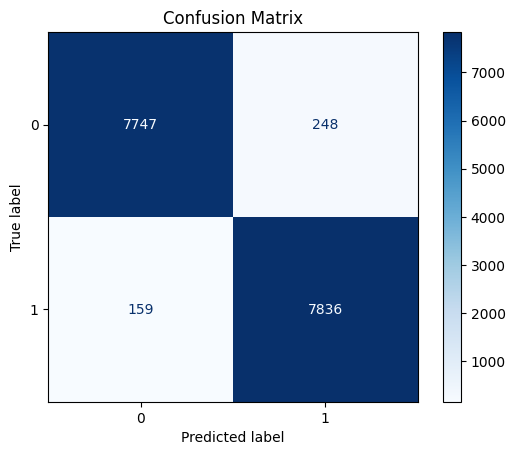

In [18]:
preds = model.predict(val_gen)
preds_labels = (preds > 0.5).astype(int).flatten()

y_true = val_gen.labels  # works if val_gen is from flow_from_directory or similar

cm = confusion_matrix(y_true, preds_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

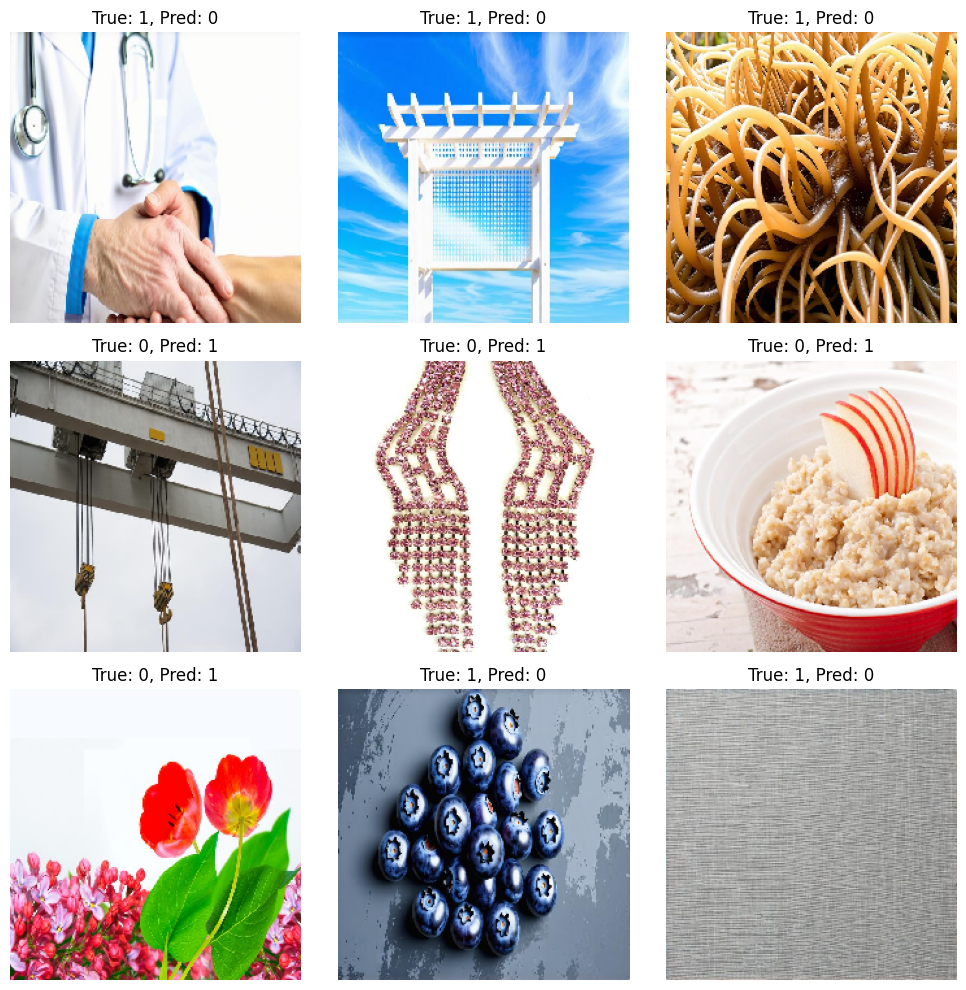

In [24]:
images = []
labels = []

val_gen.reset()
steps = len(val_gen)

for i in range(steps):
    batch_x, batch_y = next(val_gen)
    images.append(batch_x)
    labels.append(batch_y)

images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0).flatten()
misclassified_idx = np.where(preds_labels != labels)[0]

N = 12
plt.figure(figsize=(10,10))
for i, idx in enumerate(misclassified_idx[:N]):
    plt.subplot(3,3,i+1)
    
    img = images[idx]
    if img.max() <= 1.0:  
        img = img
    else:
        img = img.astype('uint8')  
    
    plt.imshow(img)
    plt.title(f"True: {labels[idx]}, Pred: {preds_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()



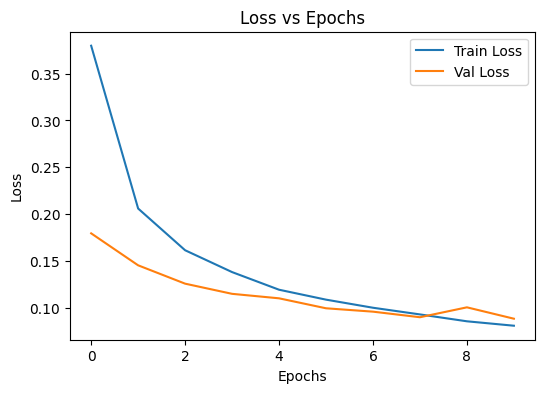

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

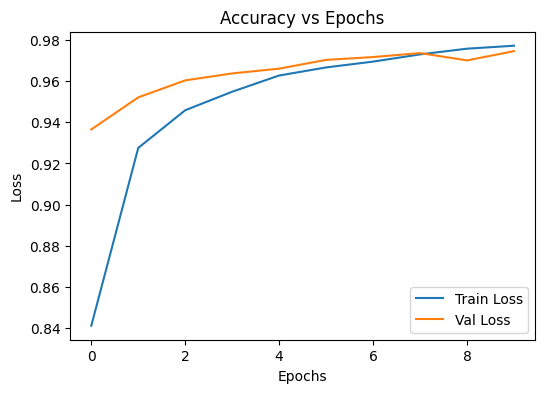

In [17]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Loss')
plt.plot(history.history['val_accuracy'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


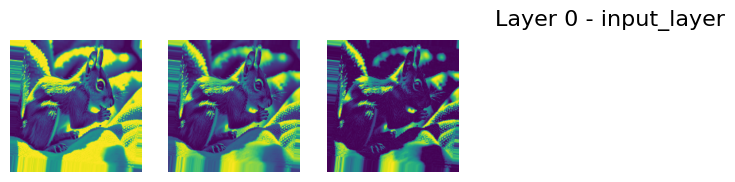

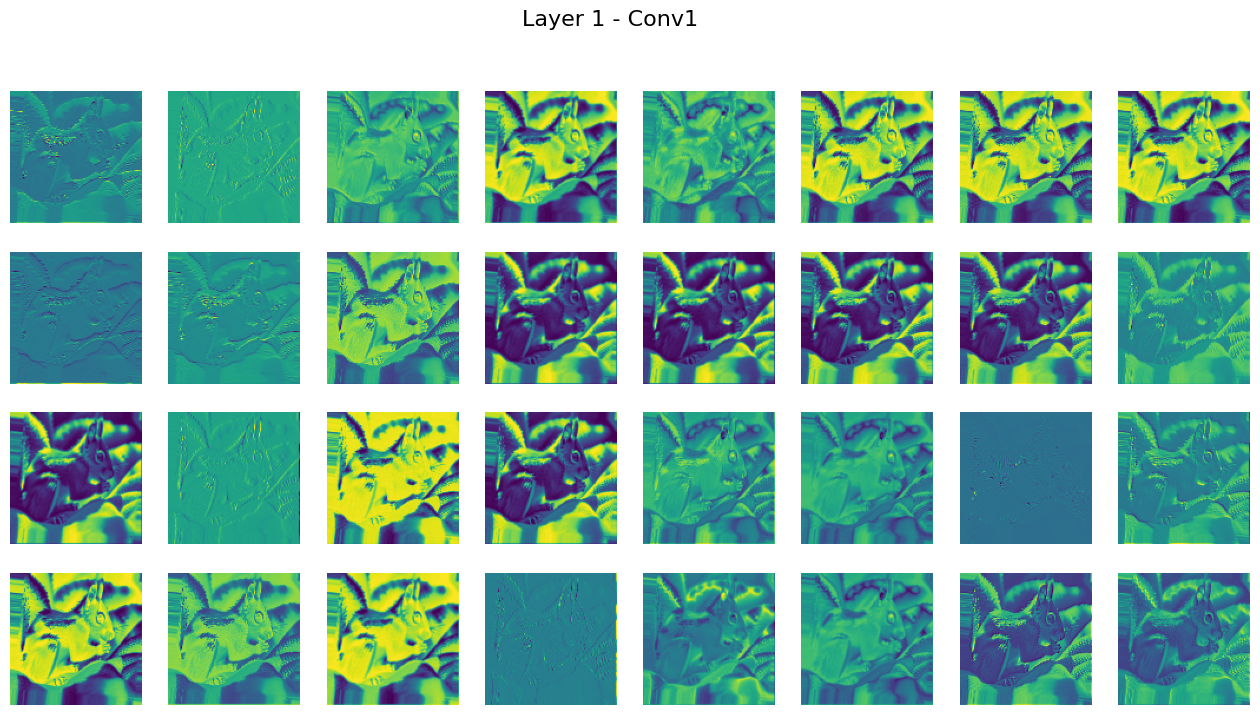

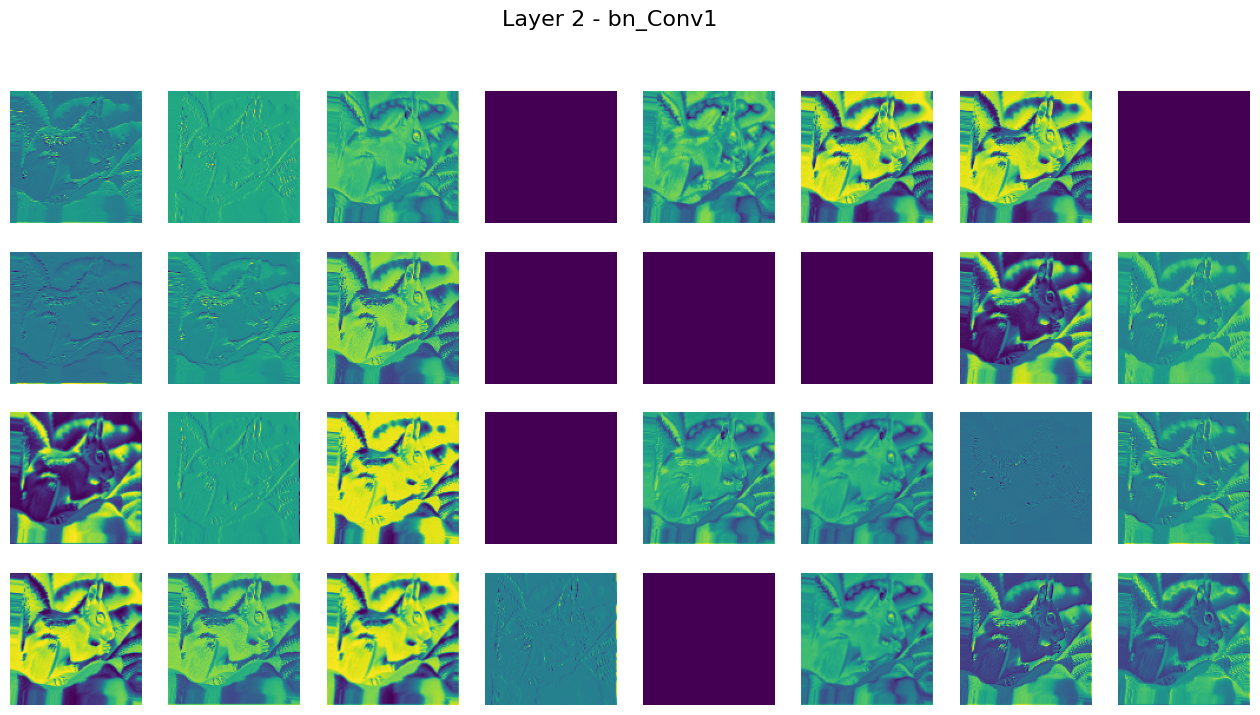

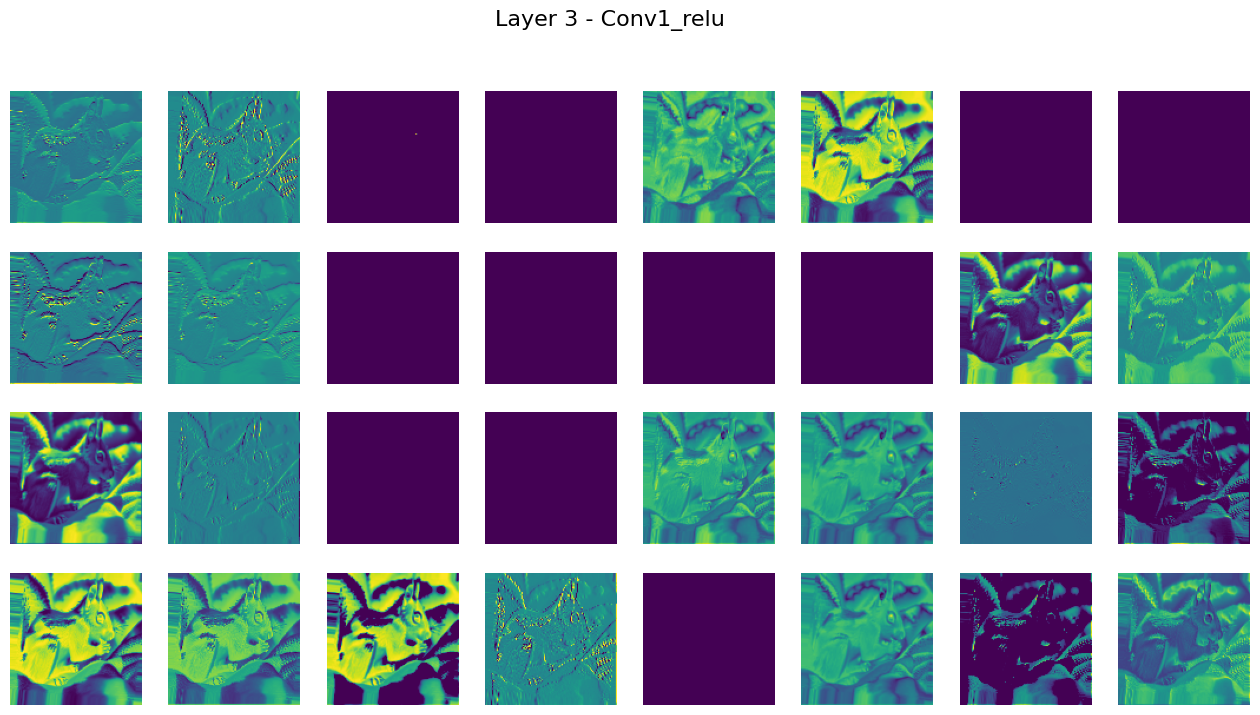

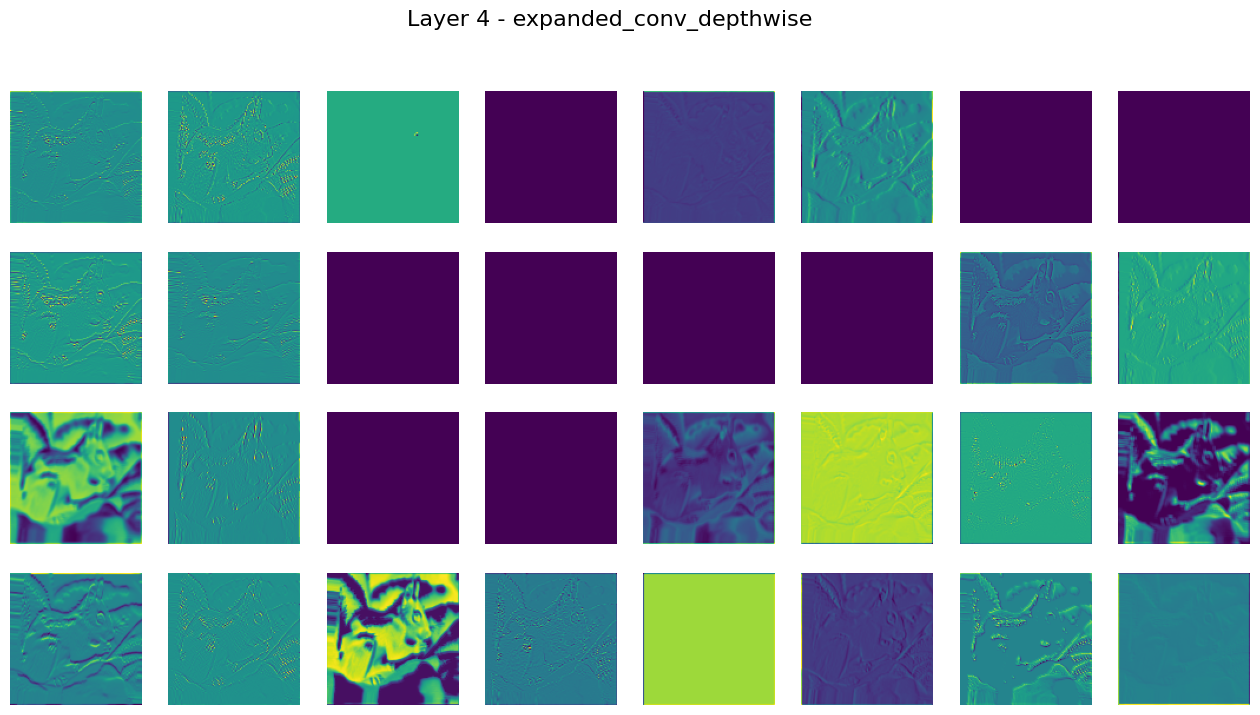

In [25]:
from tensorflow.keras.models import Model
import math
import matplotlib.pyplot as plt

sample_img, _ = next(train_gen) 
img = sample_img[0:1]

base = model.layers[0]

num_layers_to_inspect = 5
layer_outputs = [base.get_layer(base.layers[i].name).output for i in range(num_layers_to_inspect)]

activation_model = Model(inputs=base.input, outputs=layer_outputs)

activations = activation_model.predict(img)

for layer_idx, layer_activation in enumerate(activations):
    num_features = layer_activation.shape[-1]  
    size = layer_activation.shape[1]  

    cols = 8
    rows = math.ceil(num_features / cols)

    plt.figure(figsize=(cols*2, rows*2))
    for i in range(num_features):
        plt.subplot(rows, cols, i+1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Layer {layer_idx} - {base.layers[layer_idx].name}', fontsize=16)
    plt.show()
